In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from matplotlib import collections  as mc

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

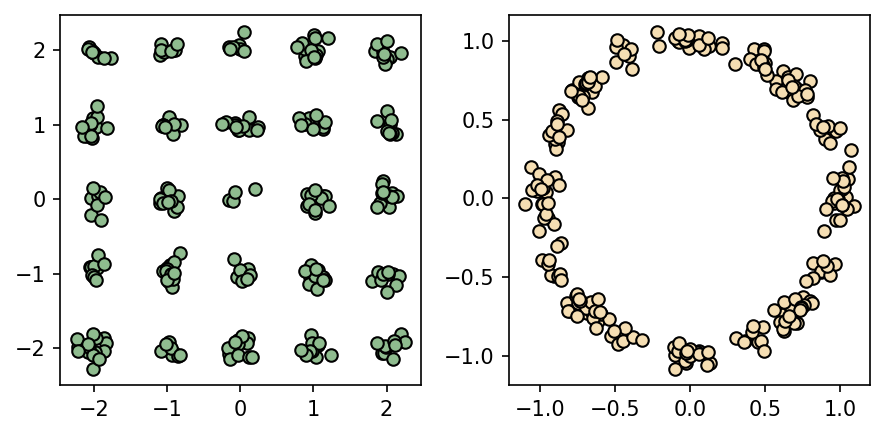

In [2]:
class ToyAlteredDataset:
    def __init__(self, grid_size=5, sigma_y=0.05):
        self.grid_size = grid_size
        self.sigma_y = sigma_y
        self.centers = torch.tensor([[i, j] for i in range(grid_size) for j in range(grid_size)], dtype=torch.float32)
        self.centers -= (grid_size - 1) / 2
        self.weights = torch.ones(len(self.centers)) / len(self.centers)
        self.stds = torch.ones(len(self.centers), 1) * 0.1

    def forward_model(self, x,alpha=0.01):
        return x / (torch.norm(x, dim=1, keepdim=True) + alpha)
    
    def sample(self, n_samples):
        center_idxs = torch.multinomial(self.weights, n_samples, replacement=True)
        samples = self.centers[center_idxs] + torch.randn(n_samples, 2) * self.stds[center_idxs]
        return samples
    
    def transform(self, x):
        return self.forward_model(x) + torch.randn(x.shape[0], 2,device=x.device) * self.sigma_y
    

dataset = ToyAlteredDataset(grid_size=5, sigma_y=0.05)
X = dataset.sample(256)
Y = dataset.transform(X)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=150, sharex=False, sharey=False)
axes[0].scatter(X[:,0], X[:, 1], c='darkseagreen', edgecolors='black')
axes[1].scatter(Y[:,0], Y[:, 1], c='wheat', edgecolors='black')
fig.tight_layout()

In [3]:
def weak_sq_cost(X, T_XZ, gamma):
    X = X.flatten(start_dim=1) # flatten all dimensions except batch
    T_XZ = T_XZ.flatten(start_dim=2) # flatten all dimensions except batch and z

    l2 = (X[:,None] - T_XZ).square().sum(dim=2).mean()
    var = T_XZ.var(dim=1).sum(dim=1).mean()
    return l2 - 0.5 * gamma * var

def weak_kernel_cost(X, T_XZ, gamma):
    X = X.flatten(start_dim=1)
    T_XZ = T_XZ.flatten(start_dim=2)
    z_size = T_XZ.size(1)
    
    l2_dist = (X[:,None] - T_XZ).norm(dim=2).mean()
    kvar = .5 * torch.cdist(T_XZ, T_XZ).mean() * z_size / (z_size -1)
    return l2_dist - 0.5 * gamma * kvar

In [4]:
class Modelf(nn.Module):
    def __init__(self):
        super(Modelf, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.network(x)
    
class ModelT(nn.Module):
    def __init__(self):
        super(ModelT, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2+2, 128), 
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, xz):
        return self.network(xz)

In [5]:
def train(model_T, model_f, optimizer_T, optimizer_f, max_steps, dataset, T_iters, batch_size,z_size,cost_function,XZ_fixed, X_fixed, Y_fixed,gamma=1.0):
    """
    Train the model_T and model_f using the given optimizers and cost function.

    Args:
    model_T: torch.nn.Module, the T model to train
    model_f: torch.nn.Module, the f model to train
    optimizer_T: torch.optim.Optimizer, the optimizer for model_T
    optimizer_f: torch.optim.Optimizer, the optimizer for model_f
    max_steps: int, the number of training steps to do
    dataset: torch.utils.data.Dataset, the dataset to sample from
    T_iters: int, the number of iterations to train model_T per step
    batch_size: int, the number of samples to draw from the dataset per step
    z_size: int, the number of noise vectors to sample per sample from the dataset
    cost_function: function, the cost function to use for training
    XZ_fixed: torch.Tensor, the fixed samples to use for plotting
    X_fixed: torch.Tensor, the fixed samples to use for plotting
    Y_fixed: torch.Tensor, the fixed samples to use for plotting
    """
    for step in tqdm(range(max_steps)):
        
        # Optimize T
        model_T.train()
        model_f.eval()

        for _ in range(T_iters):
            X = dataset.sample(batch_size).to(DEVICE)
            Z = torch.randn(batch_size, z_size, 2).to(DEVICE)

            XZ = torch.cat((X[:,None].repeat(1,z_size,1), Z), dim=2)
            T_XZ = model_T(XZ)

            T_loss = cost_function(X, T_XZ, gamma) - model_f(T_XZ).mean()

            optimizer_T.zero_grad()
            T_loss.backward()
            optimizer_T.step()
        
        # Optimize f
        model_T.eval()
        model_f.train()

        X = dataset.sample(batch_size).to(DEVICE)
        Y = dataset.transform(X)
        Z = torch.randn(batch_size, z_size, 2).to(DEVICE)
        XZ = torch.cat((X[:,None].repeat(1,z_size,1), Z), dim=2)

        T_XZ = model_T(XZ)
        f_loss = model_f(T_XZ).mean() - model_f(Y).mean()
        
        optimizer_f.zero_grad()
        f_loss.backward()
        optimizer_f.step()
    
        # to keep output remove clear_output(wait=True) and increase the value in step % value
        if step % 50 == 0: 
            clear_output(wait=True)
            print("Step", step)
            print("T_loss", T_loss.item())
            print("f_loss", f_loss.item())

            plot_results(gamma, XZ_fixed, X_fixed, Y_fixed, model_T,z_size)



def plot_results(gamma, XZ_fixed, X_fixed, Y_fixed, T,z_size):
    print('gamma={}'.format(gamma))
    fig, axes = plt.subplots(1, 4, figsize=(12,3), dpi=150, sharex=True, sharey=True)
    XZ_fixed = XZ_fixed.to(DEVICE)
    with torch.no_grad():
        T_XZ_fixed = T(XZ_fixed.flatten(start_dim=0, end_dim=1)).permute(1,0).reshape(-1,X_fixed.shape[0],z_size).permute(1,2,0).to('cpu').numpy()
        XZ_fixed = XZ_fixed.to('cpu').numpy()

    nb_lines = X_fixed.shape[0]//4
    lines = list(zip(XZ_fixed[:nb_lines,:,:2].reshape(-1,2), T_XZ_fixed[:nb_lines].reshape(-1,2)))
    axes[0].set_xlim(-2.5, 2.5); axes[0].set_ylim(-2.5, 2.5)

    lc = mc.LineCollection(lines, linewidths=0.5, color='black')
    axes[0].scatter(X_fixed[:nb_lines,0], X_fixed[:nb_lines, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mu$')
    axes[1].add_collection(lc)
    axes[1].scatter(X_fixed[:nb_lines,0], X_fixed[:nb_lines, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mu$')
    axes[1].scatter(T_XZ_fixed[:nb_lines].reshape(nb_lines*z_size,-1)[:,0], T_XZ_fixed[:nb_lines].reshape(nb_lines*z_size,-1)[:,1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $T(x,z)$')
    axes[2].scatter(T_XZ_fixed[:,0,0], T_XZ_fixed[:,0,1], c='tomato', edgecolors='black', label=r'Mapped $T(x,z)$')
    axes[3].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', label=r'Target $y\sim\nu$')
    axes[0].legend(loc='upper right');axes[1].legend(loc='upper right'); axes[2].legend(loc='upper right'); axes[3].legend(loc='upper right')
    fig.tight_layout()
    plt.show()

In [6]:
torch.manual_seed(1)

z_size = 4

# Fixed data for plotting at every iterations
X_fixed = dataset.sample(256)
Y_fixed = dataset.transform(X_fixed)
Z_fixed = torch.randn(256, z_size, 2)
X_fixed_expanded = X_fixed[:, None, :].repeat(1, z_size, 1)
XZ_fixed = torch.cat((X_fixed_expanded, Z_fixed), dim=2).float()

Step 500
T_loss 2.9011549949645996
f_loss -0.06016063690185547
gamma=1.0


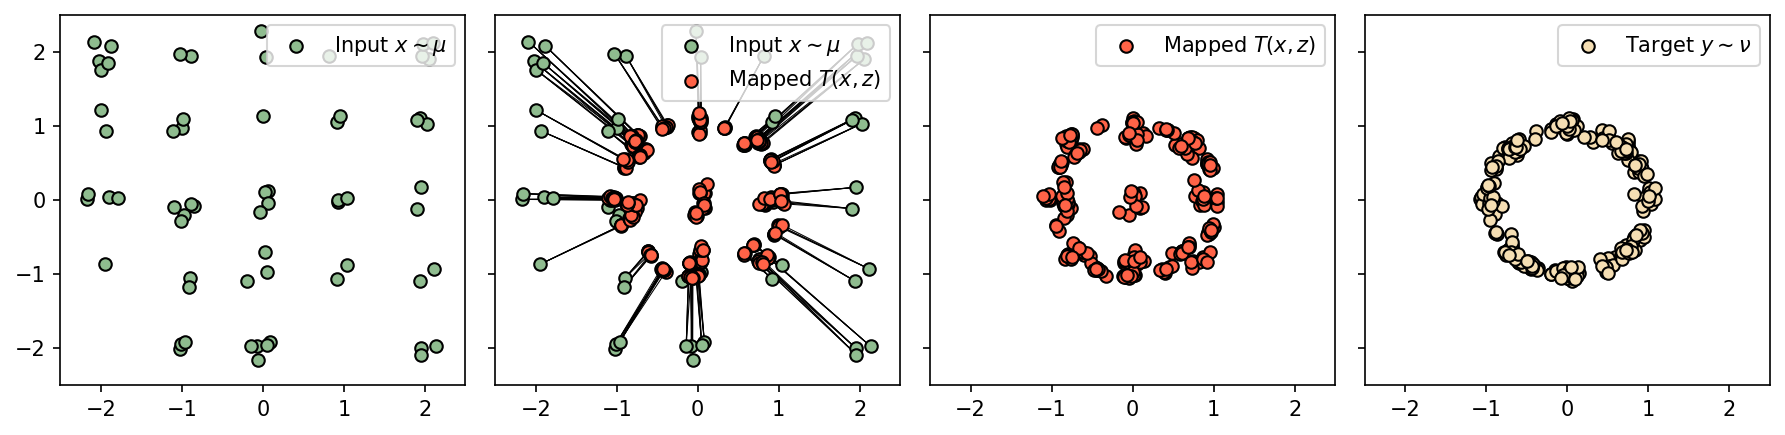

KeyboardInterrupt: 

In [7]:
print("QUADRATIC COST")
torch.manual_seed(1)

model_T = ModelT().to(DEVICE)
model_f = Modelf().to(DEVICE)

optim_T = torch.optim.Adam(model_T.parameters(), lr=1e-4, weight_decay=1e-10)
optim_f = torch.optim.Adam(model_f.parameters(), lr=1e-4, weight_decay=1e-10)

train(model_T, model_f, optim_T, optim_f,max_steps=3000, dataset=dataset, T_iters=10, batch_size=64, z_size=z_size, cost_function=weak_sq_cost, XZ_fixed=XZ_fixed, X_fixed=X_fixed, Y_fixed=Y_fixed,gamma=1.0)

Step 700
T_loss 1.8999830484390259
f_loss -0.01966714859008789
gamma=1.0


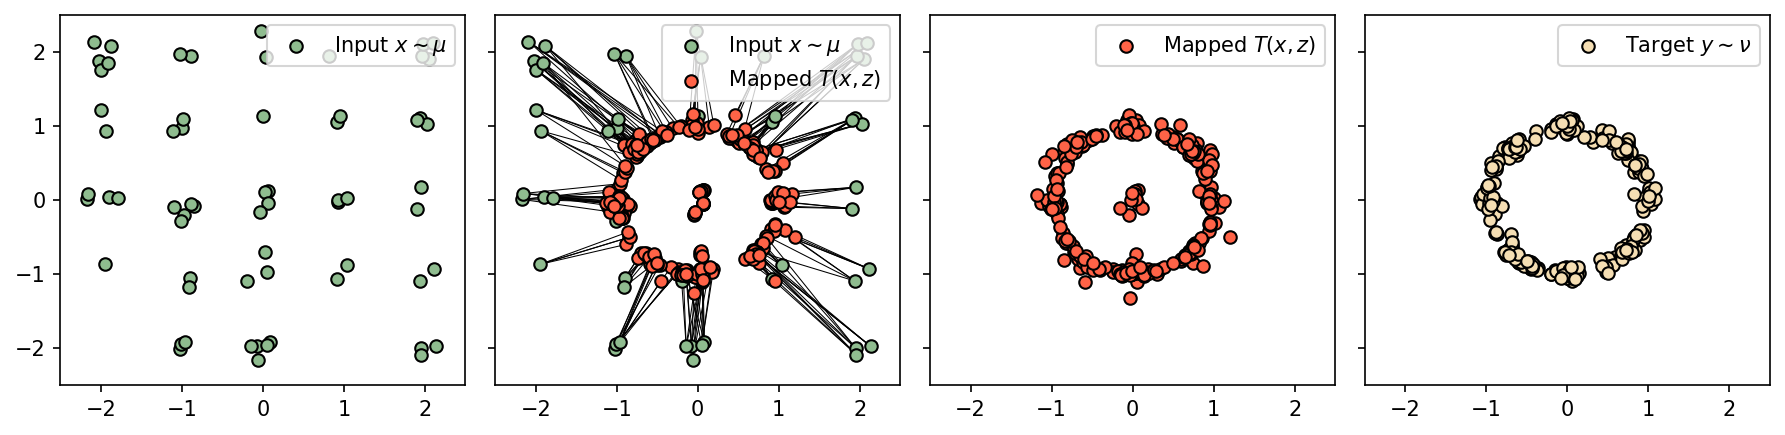

KeyboardInterrupt: 

In [8]:
print("WEAK KERNEL COST")
torch.manual_seed(1)

model_T = ModelT().to(DEVICE)
model_f = Modelf().to(DEVICE)

optim_T = torch.optim.Adam(model_T.parameters(), lr=1e-4, weight_decay=1e-10)
optim_f = torch.optim.Adam(model_f.parameters(), lr=1e-4, weight_decay=1e-10)

train(model_T, model_f, optim_T, optim_f,max_steps=3000, dataset=dataset, T_iters=10, batch_size=64, z_size=z_size, cost_function=weak_kernel_cost, XZ_fixed=XZ_fixed, X_fixed=X_fixed, Y_fixed=Y_fixed,gamma=1.0)